#                              Amazon fine food reviews 
### Objective
   To determine whether the review is positive or negative 
   
   Following are the steps we should follow -
   
   1. Dataset overview
   2. Loading dataset
   3. Exploratory data analysis
   4. Data Preprocessing
   5. Training and Testing
   6. Modeling
   7. Predictions


#### 1. Dataset overview : 

Number of reviews: 568,454                                               
Number of users: 256,059                                          
Number of products: 74,258                                      
Timespan: Oct 1999 — Oct 2012                                         
Number of columns in data: 10     

Below columns are present in the dataset - 

1. Id
2. ProductId - unique identifier for the product
3. UserId - unique identifier for the user
4. ProfileName - Name of profile 
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator — number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

#### 2. Loading the dataset : 


In [1]:
# import required libraries
import numpy as np
import pandas as pd
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# Loading data using pandas
df = pd.read_csv('Reviews.csv')
df.head()                          # display first five rows 

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
df.shape                            # display number of rows and columns

(568454, 10)

In [4]:
df.groupby('Score').size()          # group by Score column 

Score
1     52268
2     29769
3     42640
4     80655
5    363122
dtype: int64

#### 3. Exploratory data analysis :

##### Data cleaning : Deduplication
It is observed that reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results.                             
Following is an example:

In [5]:
df[(df['Score'] != 3) & (df['UserId'] == 'AR5J8UI46CURR')]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
73790,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
78444,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
138276,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
138316,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
155048,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above, same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text. On doing analysis it was found that

ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)

ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

It was inferred that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy, we will eliminate the rows having same parameters.

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delete the others. 

For above example, only review for ProductId=B000HDOPZG remains. This method ensures that there is only one representative for each product.

In [6]:
# sort data in ascending order according to ProductId
sorted_data = df.sort_values('ProductId', axis=0, ascending=True, inplace=False,kind='quicksort',na_position='last')

In [7]:
# Deduplication of data
final_data = sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final_data.shape

(393933, 10)

In [8]:
final_data = final_data[final_data.HelpfulnessNumerator <= final_data.HelpfulnessDenominator]
final_data.shape

(393931, 10)

In [9]:
final_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
150528,150529,0006641040,A25ACLV5KPB4W,"Matt Hetling ""Matt""",0,1,4,1108425600,"Nice cadence, catchy rhymes",In June<br />I saw a charming group<br />of ro...
150506,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,4,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
150505,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,4,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
150504,150505,0006641040,A2PTSM496CF40Z,"Jason A. Teeple ""Nobody made a greater mistak...",1,1,4,1210809600,A classic,Get the movie or sound track and sing along wi...
150503,150504,0006641040,AQEYF1AXARWJZ,"Les Sinclair ""book maven""",1,1,4,1212278400,Chicken Soup with Rice,A very entertaining rhyming story--cleaver and...


In [10]:
# Checking to see how much % of data still remains
(final_data['Id'].size*1.0)/(df['Id'].size*1.0)*100

69.29865917031105

In [11]:
final_data['Positivity'] = np.where(final_data['Score'] > 3, 1, 0)
final_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Positivity
150528,150529,0006641040,A25ACLV5KPB4W,"Matt Hetling ""Matt""",0,1,4,1108425600,"Nice cadence, catchy rhymes",In June<br />I saw a charming group<br />of ro...,1
150506,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,4,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,1
150505,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,4,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",1
150504,150505,0006641040,A2PTSM496CF40Z,"Jason A. Teeple ""Nobody made a greater mistak...",1,1,4,1210809600,A classic,Get the movie or sound track and sing along wi...,1
150503,150504,0006641040,AQEYF1AXARWJZ,"Les Sinclair ""book maven""",1,1,4,1212278400,Chicken Soup with Rice,A very entertaining rhyming story--cleaver and...,1


In [12]:
# How many positive and negative reviews are present in our dataset
final_data['Positivity'].value_counts()

1    307052
0     86879
Name: Positivity, dtype: int64

#### 4. Data Preprocessing :


In data/text preprocessing phase, we do the following steps -

1. Remove html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of word is greater than 2 (as it was researched that there is no adjective in 2 letters)
5. Convert the word to lowercase
6. Remove stopwords
7. Finally Snowball Stemming the word (it was observed to be better than Porter Stemming)

In [13]:
# printing some reviews
txt_0 = final_data['Text'].values[0]
txt_1000 = final_data['Text'].values[1000]
print(txt_0)
print('='* 125)
print(txt_1000)

In June<br />I saw a charming group<br />of roses all begin<br />to droop<br />I pepped them up<br />with chicken soup!<br />Sprinkle once<br />sprinkle twice<br />sprinkle chicken soup<br />with rice<br /><br />This is a great book to teach children the months of the year. The repetition of the phrases and the funny little stories with accompanying pictures make for an ideal bedtime read. This isn't nearly as good as some of Sendak's other books (like Where the Wild Things are or Pierre: The Boy Who Didn't Care), but it still carries his unique brand of charm.
Its a great snack for icecream lovers who have teeth sensitve to cold.<br />All the flavor u want and no mater how much or fast u eat no brain frezze.<br />I found it best when its cold out side i can still have my icecream and not fell like im frezzing.<br />Its a great value price /per product. And has a long shelf life making it a good survival snack.


In [14]:
# replace substrings with re module
def correct_phrase(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can't", "can not", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    return phrase

In [15]:
txt_0 = correct_phrase(txt_0)  
print(txt_0)
print("="* 125)
txt_1000 = correct_phrase(txt_1000)
print(txt_1000)

In June<br />I saw a charming group<br />of roses all begin<br />to droop<br />I pepped them up<br />with chicken soup!<br />Sprinkle once<br />sprinkle twice<br />sprinkle chicken soup<br />with rice<br /><br />This is a great book to teach children the months of the year. The repetition of the phrases and the funny little stories with accompanying pictures make for an ideal bedtime read. This isn not nearly as good as some of Sendak is other books (like Where the Wild Things are or Pierre: The Boy Who Didn not Care), but it still carries his unique brand of charm.
Its a great snack for icecream lovers who have teeth sensitve to cold.<br />All the flavor u want and no mater how much or fast u eat no brain frezze.<br />I found it best when its cold out side i can still have my icecream and not fell like im frezzing.<br />Its a great value price /per product. And has a long shelf life making it a good survival snack.


In [16]:
# source - https://gist.github.com/sebleier/554280
# we are removing the words present in stopwords list
# <br /><br /> ==> after the above steps, we are getting "br br", we are including them in stopwords list

stopwords = set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [17]:
# Apply preprocessing on reviews 
# tqdm is for printing status bar

from bs4 import BeautifulSoup
from tqdm import tqdm
preprocessed_reviews = []

for txt in tqdm(final_data['Text'].values):
    txt = re.sub(r"http\S+", "", txt)                    # remove urls
    txt = BeautifulSoup(txt, 'lxml').get_text()          # remove tags from element
    txt = correct_phrase(txt)                            # function defined above
    txt = re.sub("\S*\d\S*", "", txt).strip()            # remove words with numbers
    txt = re.sub('[^A-Za-z0-9]+', ' ', txt)              # remove special characters
    txt = ' '.join(a.lower() for a in txt.split() if a.lower() not in stopwords)
    preprocessed_reviews.append(txt.strip())

100%|████████████████████████████████| 393931/393931 [05:47<00:00, 1132.75it/s]


In [18]:
print(final_data['Text'].values[555])
print('-'*100)
print(preprocessed_reviews[555])

I had mole problems and I killed the bugs.  I had killed the whole yard to replant and don't know if there were less bugs in the first place, but I spread insecticide.  I don't have a mole problem now.  Coincidence?
----------------------------------------------------------------------------------------------------
mole problems killed bugs killed whole yard replant not know less bugs first place spread insecticide not mole problem coincidence


In [19]:
final_data['new_Text'] = preprocessed_reviews

In [20]:
print(final_data.iloc[555,:])

Id                                                                   209148
ProductId                                                        B00004RAMY
UserId                                                       A1G0ET192GSVRC
ProfileName                                                           DaveB
HelpfulnessNumerator                                                      0
HelpfulnessDenominator                                                    0
Score                                                                     5
Time                                                             1345420800
Summary                                    Kill the bugs in your yard first
Text                      I had mole problems and I killed the bugs.  I ...
Positivity                                                                1
new_Text                  mole problems killed bugs killed whole yard re...
Name: 209147, dtype: object


### Model building
#### Featurization - Bag of Words

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [22]:
final_data1 = final_data.sort_values(by=['Time'],ascending=False)
final_data2 = final_data1.head(100000)
x = final_data2['new_Text']
y = final_data2['Positivity']

x_tr,x_test,y_tr,y_test=train_test_split(x, y, test_size=0.2,shuffle=False, random_state=20)

In [23]:
print(x_tr.shape,x_test.shape,y_tr.shape,y_test.shape)

(80000,) (20000,) (80000,) (20000,)


In [24]:
# Bag of Words - Unigram - Logistic Regression
import warnings
warnings.filterwarnings("ignore")

bow = CountVectorizer()
x_tr_uni = bow.fit_transform(x_tr)
x_test_uni= bow.transform(x_test)

# The idea behind StandardScaler is that it will transform your data such that 
# its distribution will have a mean value 0 and standard deviation of 1.
from sklearn.preprocessing import StandardScaler  
x_tr_uni = StandardScaler(with_mean = False).fit_transform(x_tr_uni)
x_test_uni = StandardScaler(with_mean = False).fit_transform(x_test_uni)

#### RandomSearchCV - Finding the optimal C using RandomSearchCV

In [26]:
from scipy.stats import uniform
LR = LogisticRegression(penalty='l1')
C_value = {'C':uniform()}
gsv = RandomizedSearchCV(LR,C_value,cv=5,verbose=1,scoring='f1_micro',n_jobs=-1)
gsv.fit(x_tr_uni,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
optimal_C=gsv.best_score_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  8.4min finished


Best HyperParameter:  {'C': 0.02816382109927873}
0.8719375


#### Finding the accuracy, F1-score in test data using optimal C

In [28]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

Accuracy on test set: 81.385%
Precision on test set: 0.747
Recall on test set: 0.756
F1-Score on test set: 0.751


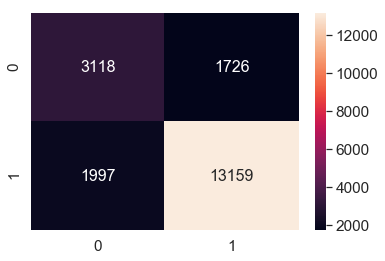

In [29]:
LR = LogisticRegression(penalty='l1',C=optimal_C)
LR.fit(x_tr_uni,y_tr)
y_pred = LR.predict(x_test_uni)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

Using Logistic Regression model on Amazon Fine food reviews dataset, we get following results - 

Accuracy  : 81.385%                                                                          
Precision : 0.747                                                            
Recall    : 0.756                                                                     
F1-Score  : 0.751